In [0]:
from __future__ import print_function
%matplotlib inline
import json
import os.path
import random as ra
import tensorflow as tf
import numpy as np
import keras
from keras.optimizers import Adam, Adadelta ,Adamax
from keras import backend as K
from keras.layers import Bidirectional,Conv2DTranspose,Input,Add, Activation, Dense, Dropout, BatchNormalization, Reshape, Permute, Lambda, Embedding, LSTM, Conv2D, MaxPooling2D, TimeDistributed, RepeatVector, Concatenate, Multiply, Flatten
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy import ndimage, misc
from imageio import imread
from keras.utils.vis_utils import plot_model
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

Using TensorFlow backend.


In [0]:
path = 'Training'

**For Loading Data**

In [0]:
def load_data(n, vocab_size, sequence_length, tokenizer=None):

    questions_path = path + '/Quest_Answers.json'
    images_path = path + '/images/' 

    x_text = []     # List of questions
    x_image = []    # List of images
    y = []          # List of answers
    num_labels = 0  # Current number of labels, used to create index mapping
    labels = {}     # Dictionary mapping of ints to labels
    images = {}     # Dictionary of images, to minimize number of imread ops
    target_height, target_width = 96, 96
    print('Loading data...')

 
    with open(questions_path) as f:
        data = json.load(f)

    data = data['quest_answers'][0:n]
    for i in range(len(data)):
        if (data[i]['Answer'] is False):
            data[i]['Answer'] = 'False'
        if (data[i]['Answer'] is True):
            data[i]['Answer'] = 'True'
    print('JSON subset saved to file...')

    print('Storing image data...')

    for q in data[0:n]:
        if not q['Answer'] in labels :
            labels[q['Answer']] = num_labels
            num_labels += 1
        

        # Create an index for each image
        if not q['Image'] in images:
            images[q['Image']] = imread(images_path + q['Image'] + '.png', pilmode='RGB')
            images[q['Image']] = cv2.resize(images[q['Image']], (target_height, target_width))

        x_text.append(q['Question'])
        x_image.append(images[q['Image']])
        y.append(labels[q['Answer']])

    # Convert question corpus into sequential encoding for LSTM
    print('Processing text data...')
    
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(x_text)
    sequences = tokenizer.texts_to_sequences(x_text)
    x_text = sequence.pad_sequences(sequences, maxlen=sequence_length)

    # Convert x_image to np array
    x_image = np.array(x_image)
    
    # Convert labels to categorical labels
    y = keras.utils.to_categorical(y, num_labels)
    print(type(x_image))
    print(len(data))
    print('Text: ', x_text.shape)
    print('Image: ', x_image.shape)
    print('Labels: ', y.shape)
    print(num_labels)
    return ([x_text, x_image], y), num_labels, tokenizer


**Scaling Image Input**

In [0]:
def process_image(x):
    #I have done resizing in the load_model function
#     target_height, target_width = 96, 96
#     x = tf.image.resize_images(x, (target_height, target_width), method=tf.image.ResizeMethod.AREA)
#     x= cv2.resize(x,(target_height, target_width))
    x = x/255
    return x

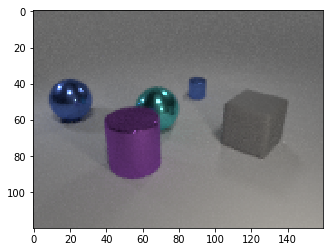

In [0]:
path_Im = path + '/images/CLEVR_new_000000.png' 
imgx  = imread(path_Im, pilmode='RGB')
plt.imshow(imgx)

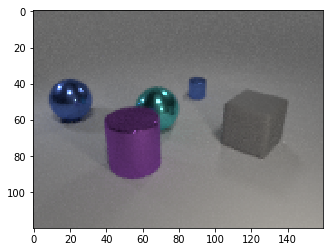

In [0]:
plt.imshow(process_image(imgx))

In [0]:
word_feature_size           = 128
number_of_hidden_units_LSTM = 64
number_of_hidden_units      = 1024
dropout_pct                 = 0.5

img_rows, img_cols = 96, 96
image_input_shape = (img_rows, img_cols, 3)

In [0]:
samples = 80000
vocab_size = 115 # Found out that there are 115 (less than that) unique words in the dataset questions.
sequence_length = 42 #I know the maximum length of the question is 42 words. Found out

In [0]:
(x_train, y_train), num_labels, tokenizer = load_data(samples, vocab_size, sequence_length)
word_index = tokenizer.word_index

Loading data...
JSON subset saved to file...
Storing image data...
Processing text data...
<class 'numpy.ndarray'>
80000
Text:  (80000, 42)
Image:  (80000, 96, 96, 3)
Labels:  (80000, 26)
26


In [0]:
K.image_data_format()

'channels_last'

**Defining The Model - CNN Head**

In [0]:
# model_im = Sequential()
# model_im.add(Lambda)

In [0]:
# Image model.. .
image_inputs = Input(shape =image_input_shape)
image_x = Lambda(process_image)(image_inputs)

image_x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(image_x)
image_x = BatchNormalization()(image_x)
image_x = MaxPooling2D(pool_size=(3,3)) (image_x)
image_x = Dropout(0.25) (image_x)

image_x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(image_x)
image_x = BatchNormalization()(image_x)


image_x = MaxPooling2D(pool_size=4) (image_x)
image_x = Dropout(0.30)(image_x)
print(image_x.shape)

image_x  = Reshape((64,16))(image_x)

# image_x = Dense()
print(image_x.shape)

# image_x = Permute((2,1))(image_x)
# # print(image_x.shape)


branch_outputs = []
out = Lambda(lambda x: x[:, 0])(image_x)
out = Dense(32)(out)
branch_outputs.append(out)
out1 = Lambda(lambda x: x[:, 1])(image_x)
out1 = Dense(32)(out1)
branch_outputs.append(out1)
out2 = Lambda(lambda x: x[:, 2])(image_x)
out2 = Dense(32)(out2)
branch_outputs.append(out2)
out3 = Lambda(lambda x: x[:, 3])(image_x)
out3 = Dense(32)(out3)
branch_outputs.append(out3)
out4 = Lambda(lambda x: x[:, 4])(image_x)
out4 = Dense(32)(out4)
branch_outputs.append(out4)
out5 = Lambda(lambda x: x[:, 5])(image_x)
out5 = Dense(32)(out5)
branch_outputs.append(out5)
out6 = Lambda(lambda x: x[:, 6])(image_x)
out6 = Dense(32)(out6)
branch_outputs.append(out6)
out7 = Lambda(lambda x: x[:, 7])(image_x)
out7 = Dense(32)(out7)
branch_outputs.append(out7)
out8 = Lambda(lambda x: x[:, 8])(image_x)
out8 = Dense(32)(out8)
branch_outputs.append(out8)
out9 = Lambda(lambda x: x[:, 9])(image_x)
out9 = Dense(32)(out9)
branch_outputs.append(out9)
out10 = Lambda(lambda x: x[:, 10])(image_x)
out10 = Dense(32)(out10)
branch_outputs.append(out10)
out11 = Lambda(lambda x: x[:, 11])(image_x)
out11 = Dense(32)(out11)
branch_outputs.append(out11)
out12 = Lambda(lambda x: x[:, 12])(image_x)
out12 = Dense(32)(out12)
branch_outputs.append(out12)
out13 = Lambda(lambda x: x[:, 13])(image_x)
out13 = Dense(32)(out13)
branch_outputs.append(out13)
out14 = Lambda(lambda x: x[:, 14])(image_x)
out14 = Dense(32)(out14)
branch_outputs.append(out14)
out15 = Lambda(lambda x: x[:, 14])(image_x)
out15 = Dense(32)(out15)
branch_outputs.append(out15)
    
# Concatenating together the per-channel results:

# hi = Concatenate(axis = 1)([out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11,out12,out13,out14,out15])
hi = Concatenate(axis = 1)(branch_outputs)#N*16*32

print(hi.shape)

# model_im = Model(inputs = image_inputs, outputs = hi)
# print(model_im.summary())

(?, 8, 8, 16)
(?, 64, 16)
(?, 512)


In [0]:
# plot_model(model_im,to_file='skip.png')

In [0]:
# Language Model
embeddings_index = {}
f = open('glove.6B.50d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


**Defining The Model -RNN Head**

In [0]:
EMBEDDING_DIM = 50
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=sequence_length,
                            trainable=True)

In [0]:
text_inputs = Input(shape=(sequence_length,))
# text_x = embedding_layer(text_inputs) #comment if you dont want to use glove
text_x = Embedding(len(word_index)+1,word_feature_size,input_length=sequence_length)(text_inputs)#comment if you dont want to use Keras embedding
text_x = LSTM(number_of_hidden_units_LSTM, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(text_x)
text_x = LSTM(number_of_hidden_units_LSTM, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(text_x)                    
print(text_x.shape)
# model2 = Model(text_inputs, text_x)
# print(model2.summary())

(?, 64)


In [0]:
import keras.backend as K 

**Stacked Attention Layers**

In [0]:
# def attention(hi,text_x): These are the attention layers.We construct 2 layers of stacked attention
 
hq = Dense(32)(text_x)
hq = Reshape((1,32))(hq) #N*1*32


hi_outputs = []

out16 = Lambda(lambda x: x[:, 0])(hi) 
out16  = Add()([out16,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out16 = Activation('tanh')(out16)
out16 = Dense(1,activation = 'softmax')(out16)
hi_outputs.append(out16)

out17 = Lambda(lambda x: x[:, 1])(hi) 
out17 = Add()([out17,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out17 = Activation('tanh')(out17)
out17 = Dense(1,activation = 'softmax')(out17)
hi_outputs.append(out17)

out18 = Lambda(lambda x: x[:, 2])(hi) 
out18 = Add()([out18,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out18 = Activation('tanh')(out18)
out18 = Dense(1,activation = 'softmax')(out18)
hi_outputs.append(out18)

out19 = Lambda(lambda x: x[:, 3])(hi) 
out19 = Add()([out19,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out19 = Activation('tanh')(out19)
out19 = Dense(1,activation = 'softmax')(out19)
hi_outputs.append(out19)

out20 = Lambda(lambda x: x[:, 4])(hi) 
out20 = Add()([out20,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out20 = Activation('tanh')(out20)
out20 = Dense(1,activation = 'softmax')(out20)
hi_outputs.append(out20)

out21 = Lambda(lambda x: x[:, 5])(hi) 
out21 = Add()([out21,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out21 = Activation('tanh')(out21)
out21 = Dense(1,activation = 'softmax')(out21)
hi_outputs.append(out21)

out22 = Lambda(lambda x: x[:, 6])(hi) 
out22 = Add()([out22,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out22 = Activation('tanh')(out22)
out22 = Dense(1,activation = 'softmax')(out22)
hi_outputs.append(out22)

out23 = Lambda(lambda x: x[:, 7])(hi) 
out23 = Add()([out23,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out23 = Activation('tanh')(out23)
out23 = Dense(1,activation = 'softmax')(out23)
hi_outputs.append(out23)

out24 = Lambda(lambda x: x[:, 8])(hi) 
out24 = Add()([out24,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out24 = Activation('tanh')(out24)
out24 = Dense(1,activation = 'softmax')(out24)
hi_outputs.append(out24)

out25 = Lambda(lambda x: x[:, 9])(hi) 
out25 = Add()([out25,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out25 = Activation('tanh')(out25)
out25 = Dense(1,activation = 'softmax')(out25)
hi_outputs.append(out25)

out26 = Lambda(lambda x: x[:, 10])(hi) 
out26 = Add()([out26,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out26 = Activation('tanh')(out26)
out26 = Dense(1,activation = 'softmax')(out26)
hi_outputs.append(out26)

out27 = Lambda(lambda x: x[:, 11])(hi) 
out27 = Add()([out27,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out27 = Activation('tanh')(out27)
out27 = Dense(1,activation = 'softmax')(out27)
hi_outputs.append(out27)

out28 = Lambda(lambda x: x[:, 12])(hi) 
out28 = Add()([out28,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out28 = Activation('tanh')(out28)
out28 = Dense(1,activation = 'softmax')(out28)
hi_outputs.append(out28)

out29 = Lambda(lambda x: x[:, 13])(hi) 
out29 = Add()([out29,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out29 = Activation('tanh')(out29)
out29 = Dense(1,activation = 'softmax')(out29)
hi_outputs.append(out29)

out30 = Lambda(lambda x: x[:, 14])(hi) 
out30 = Add()([out30,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out30 = Activation('tanh')(out30)
out30 = Dense(1,activation = 'softmax')(out30)
hi_outputs.append(out30)

out31 = Lambda(lambda x: x[:, 15])(hi) 
out31 = Add()([out31,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
out31 = Activation('tanh')(out31)
out31 = Dense(1,activation = 'softmax')(out31)
hi_outputs.append(out31)


pi = Concatenate(axis = 1)(hi_outputs) #N*16*1


image_y = Permute((2,1))(image_x) #N*32*16
# image_y = Flatten()(image_y)
print(image_y.shape)

multiplied_out = []


m12 = Lambda(lambda x: x[:, 0])(image_y)
m22 = Lambda(lambda y: y[:, 0])(pi)
mul2 = Lambda(lambda z: z[0] * z[1])([m12, m22])
#mul = multiply([m1,m2])
multiplied_out.append(mul2)

m13 = Lambda(lambda x: x[:, 1])(image_y)
m23 = Lambda(lambda y: y[:, 1])(pi)
mul3 = Lambda(lambda z: z[0] * z[1])([m13, m23])
#mul = multiply([m1,m2])
multiplied_out.append(mul3)

m14 = Lambda(lambda x: x[:, 2])(image_y)
m24 = Lambda(lambda y: y[:, 2])(pi)
mul4 = Lambda(lambda z: z[0] * z[1])([m14, m24])
#mul = multiply([m1,m2])
multiplied_out.append(mul4)

m15 = Lambda(lambda x: x[:, 3])(image_y)
m25 = Lambda(lambda y: y[:, 3])(pi)
mul5 = Lambda(lambda z: z[0] * z[1])([m15, m25])
#mul = multiply([m1,m2])
multiplied_out.append(mul5)

m16 = Lambda(lambda x: x[:, 4])(image_y)
m26 = Lambda(lambda y: y[:, 4])(pi)
mul6 = Lambda(lambda z: z[0] * z[1])([m16, m26])
#mul = multiply([m1,m2])
multiplied_out.append(mul6)

m17 = Lambda(lambda x: x[:, 5])(image_y)
m27 = Lambda(lambda y: y[:, 5])(pi)
mul7 = Lambda(lambda z: z[0] * z[1])([m17, m27])
#mul = multiply([m1,m2])
multiplied_out.append(mul7)

m18 = Lambda(lambda x: x[:, 6])(image_y)
m28 = Lambda(lambda y: y[:, 6])(pi)
mul8 = Lambda(lambda z: z[0] * z[1])([m18, m28])
#mul = multiply([m1,m2])
multiplied_out.append(mul8)

m19 = Lambda(lambda x: x[:, 7])(image_y)
m29 = Lambda(lambda y: y[:, 7])(pi)
mul9 = Lambda(lambda z: z[0] * z[1])([m19, m29])
#mul = multiply([m1,m2])
multiplied_out.append(mul9)

m120 = Lambda(lambda x: x[:, 8])(image_y)
m220 = Lambda(lambda y: y[:, 8])(pi)
mul20 = Lambda(lambda z: z[0] * z[1])([m120, m220])
#mul = multiply([m1,m2])
multiplied_out.append(mul20)

m121 = Lambda(lambda x: x[:, 9])(image_y)
m221 = Lambda(lambda y: y[:, 9])(pi)
mul21 = Lambda(lambda z: z[0] * z[1])([m121, m221])
#mul = multiply([m1,m2])
multiplied_out.append(mul21)

m122 = Lambda(lambda x: x[:, 10])(image_y)
m222 = Lambda(lambda y: y[:, 10])(pi)
mul22 = Lambda(lambda z: z[0] * z[1])([m122, m222])
#mul = multiply([m1,m2])
multiplied_out.append(mul22)

m123 = Lambda(lambda x: x[:, 11])(image_y)
m223 = Lambda(lambda y: y[:, 11])(pi)
mul23 = Lambda(lambda z: z[0] * z[1])([m123, m223])
#mul = multiply([m1,m2])
multiplied_out.append(mul23)

m124 = Lambda(lambda x: x[:, 12])(image_y)
m224 = Lambda(lambda y: y[:, 12])(pi)
mul24 = Lambda(lambda z: z[0] * z[1])([m124, m224])
#mul = multiply([m1,m2])
multiplied_out.append(mul24)

m125 = Lambda(lambda x: x[:, 13])(image_y)
m225 = Lambda(lambda y: y[:, 13])(pi)
mul25 = Lambda(lambda z: z[0] * z[1])([m125, m225])
#mul = multiply([m1,m2])
multiplied_out.append(mul25)

m126 = Lambda(lambda x: x[:, 14])(image_y)
m226 = Lambda(lambda y: y[:, 14])(pi)
mul26 = Lambda(lambda z: z[0] * z[1])([m126, m226])
#mul = multiply([m1,m2])
multiplied_out.append(mul26)

m127 = Lambda(lambda x: x[:, 15])(image_y)
m227 = Lambda(lambda y: y[:, 15])(pi)
mul27 = Lambda(lambda z: z[0] * z[1])([m127, m227])
#mul = multiply([m1,m2])
multiplied_out.append(mul27)


pivi = Concatenate(axis = 1)(multiplied_out) #N*16*64


print(pivi.shape)
pivi = Reshape((16,64))(pivi)
pivi0 = Lambda(lambda v: v[:, 0])(pivi)
pivi1 = Lambda(lambda v: v[:, 1])(pivi)
pivi2 = Lambda(lambda v: v[:, 2])(pivi)
pivi3 = Lambda(lambda v: v[:, 3])(pivi)
pivi4 = Lambda(lambda v: v[:, 4])(pivi)
pivi5 = Lambda(lambda v: v[:, 5])(pivi)
pivi6 = Lambda(lambda v: v[:, 6])(pivi)
pivi7 = Lambda(lambda v: v[:, 7])(pivi)
pivi8 = Lambda(lambda v: v[:, 8])(pivi)
pivi9 = Lambda(lambda v: v[:, 9])(pivi)
pivi10 = Lambda(lambda v: v[:, 10])(pivi)
pivi11 = Lambda(lambda v: v[:, 11])(pivi)
pivi12 = Lambda(lambda v: v[:, 12])(pivi)
pivi13 = Lambda(lambda v: v[:, 13])(pivi)
pivi14 = Lambda(lambda v: v[:, 14])(pivi)
pivi15 = Lambda(lambda v: v[:, 15])(pivi)
sum1 = Add()([pivi0,pivi1,pivi2,pivi3,pivi4,pivi5,pivi6,pivi7,pivi8,pivi9,pivi10,pivi11,pivi12,pivi13,pivi14,pivi15])

u = Lambda(lambda a: a[0] + a[1])([text_x,sum1])
#------------------------------------------------------------------------------------------------------------------------#
hq = Dense(32)(u)
hq = Reshape((1,32))(hq)
hi_outputs = []
ut16 = Lambda(lambda x: x[:, 0])(hi) 
ut16  = Add()([ut16,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut16 = Activation('tanh')(ut16)
ut16 = Dense(1,activation = 'softmax')(ut16)
hi_outputs.append(ut16)

ut17 = Lambda(lambda x: x[:, 1])(hi) 
ut17 = Add()([ut17,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut17 = Activation('tanh')(ut17)
ut17 = Dense(1,activation = 'softmax')(ut17)
hi_outputs.append(ut17)

ut18 = Lambda(lambda x: x[:, 2])(hi) 
ut18 = Add()([ut18,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut18 = Activation('tanh')(ut18)
ut18 = Dense(1,activation = 'softmax')(ut18)
hi_outputs.append(ut18)

ut19 = Lambda(lambda x: x[:, 3])(hi) 
ut19 = Add()([ut19,hq])   
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut19 = Activation('tanh')(ut19)
ut19 = Dense(1,activation = 'softmax')(ut19)
hi_outputs.append(ut19)

ut20 = Lambda(lambda x: x[:, 4])(hi) 
ut20 = Add()([ut20,hq])   
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut20 = Activation('tanh')(ut20)
ut20 = Dense(1,activation = 'softmax')(ut20)
hi_outputs.append(ut20)

ut21 = Lambda(lambda x: x[:, 5])(hi) 
ut21 = Add()([ut21,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut21 = Activation('tanh')(ut21)
ut21 = Dense(1,activation = 'softmax')(ut21)
hi_outputs.append(ut21)

ut22 = Lambda(lambda x: x[:, 6])(hi) 
ut22 = Add()([ut22,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut22 = Activation('tanh')(ut22)
ut22 = Dense(1,activation = 'softmax')(ut22)
hi_outputs.append(ut22)

ut23 = Lambda(lambda x: x[:, 7])(hi) 
ut23 = Add()([out23,hq])    #instead of using 3 different loops,i think the entire thing can be done using a single loop also
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut23 = Activation('tanh')(ut23)
ut23 = Dense(1,activation = 'softmax')(ut23)
hi_outputs.append(ut23)

ut24 = Lambda(lambda x: x[:, 8])(hi) 
ut24 = Add()([ut24,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut24 = Activation('tanh')(ut24)
ut24 = Dense(1,activation = 'softmax')(ut24)
hi_outputs.append(ut24)

ut25 = Lambda(lambda x: x[:, 9])(hi) 
ut25 = Add()([ut25,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut25 = Activation('tanh')(ut25)
ut25 = Dense(1,activation = 'softmax')(ut25)
hi_outputs.append(ut25)

ut26 = Lambda(lambda x: x[:, 10])(hi) 
ut26 = Add()([ut26,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut26 = Activation('tanh')(ut26)
ut26 = Dense(1,activation = 'softmax')(ut26)
hi_outputs.append(ut26)

ut27 = Lambda(lambda x: x[:, 11])(hi) 
ut27 = Add()([ut27,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut27 = Activation('tanh')(ut27)
ut27 = Dense(1,activation = 'softmax')(ut27)
hi_outputs.append(ut27)

ut28 = Lambda(lambda x: x[:, 12])(hi) 
ut28 = Add()([ut28,hq])    
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut28 = Activation('tanh')(ut28)
ut28 = Dense(1,activation = 'softmax')(ut28)
hi_outputs.append(ut28)

ut29 = Lambda(lambda x: x[:, 13])(hi) 
ut29 = Add()([ut29,hq])   
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut29 = Activation('tanh')(ut29)
ut29 = Dense(1,activation = 'softmax')(ut29)
hi_outputs.append(ut29)

ut30 = Lambda(lambda x: x[:, 14])(hi) 
ut30 = Add()([ut30,hq])   
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut30 = Activation('tanh')(ut30)
ut30 = Dense(1,activation = 'softmax')(ut30)
hi_outputs.append(ut30)

ut31 = Lambda(lambda x: x[:, 15])(hi) 
ut31 = Add()([ut31,hq])   
#   out = Lambda(lambda a: a[0] + a[1])([out,hq])
ut31 = Activation('tanh')(ut31)
ut31 = Dense(1,activation = 'softmax')(ut31)
hi_outputs.append(ut31)

pi = Concatenate(axis = 1)(hi_outputs) #N*16*1


image_y = Permute((2,1))(image_x) #N*32*16
# image_y = Flatten()(image_y)
print(image_y.shape)

multiplied_out = []


m121 = Lambda(lambda x: x[:, 0])(image_y)
m221 = Lambda(lambda y: y[:, 0])(pi)
mul21 = Lambda(lambda z: z[0] * z[1])([m121, m221])
#mul = multiply([m1,m2])
multiplied_out.append(mul21)

m131 = Lambda(lambda x: x[:, 1])(image_y)
m231 = Lambda(lambda y: y[:, 1])(pi)
mul31 = Lambda(lambda z: z[0] * z[1])([m131, m231])
#mul = multiply([m1,m2])
multiplied_out.append(mul31)

m141 = Lambda(lambda x: x[:, 2])(image_y)
m241 = Lambda(lambda y: y[:, 2])(pi)
mul41 = Lambda(lambda z: z[0] * z[1])([m141, m241])
#mul = multiply([m1,m2])
multiplied_out.append(mul41)

m151 = Lambda(lambda x: x[:, 3])(image_y)
m251 = Lambda(lambda y: y[:, 3])(pi)
mul51 = Lambda(lambda z: z[0] * z[1])([m151, m251])
#mul = multiply([m1,m2])
multiplied_out.append(mul51)

m161 = Lambda(lambda x: x[:, 4])(image_y)
m261 = Lambda(lambda y: y[:, 4])(pi)
mul61 = Lambda(lambda z: z[0] * z[1])([m161, m261])
#mul = multiply([m1,m2])
multiplied_out.append(mul61)

m171 = Lambda(lambda x: x[:, 5])(image_y)
m271 = Lambda(lambda y: y[:, 5])(pi)
mul71 = Lambda(lambda z: z[0] * z[1])([m171, m271])
#mul = multiply([m1,m2])
multiplied_out.append(mul71)

m181 = Lambda(lambda x: x[:, 6])(image_y)
m281 = Lambda(lambda y: y[:, 6])(pi)
mul81 = Lambda(lambda z: z[0] * z[1])([m181, m281])
#mul = multiply([m1,m2])
multiplied_out.append(mul81)

m191 = Lambda(lambda x: x[:, 7])(image_y)
m291 = Lambda(lambda y: y[:, 7])(pi)
mul91 = Lambda(lambda z: z[0] * z[1])([m191, m291])
#mul = multiply([m1,m2])
multiplied_out.append(mul91)

m1201 = Lambda(lambda x: x[:, 8])(image_y)
m2201 = Lambda(lambda y: y[:, 8])(pi)
mul201 = Lambda(lambda z: z[0] * z[1])([m1201, m2201])
#mul = multiply([m1,m2])
multiplied_out.append(mul201)

m1211 = Lambda(lambda x: x[:, 9])(image_y)
m2211 = Lambda(lambda y: y[:, 9])(pi)
mul211 = Lambda(lambda z: z[0] * z[1])([m1211, m2211])
#mul = multiply([m1,m2])
multiplied_out.append(mul211)

m1221 = Lambda(lambda x: x[:, 10])(image_y)
m2221 = Lambda(lambda y: y[:, 10])(pi)
mul221 = Lambda(lambda z: z[0] * z[1])([m1221, m2221])
#mul = multiply([m1,m2])
multiplied_out.append(mul221)

m1231 = Lambda(lambda x: x[:, 11])(image_y)
m2231 = Lambda(lambda y: y[:, 11])(pi)
mul231 = Lambda(lambda z: z[0] * z[1])([m1231, m2231])
#mul = multiply([m1,m2])
multiplied_out.append(mul231)

m1241 = Lambda(lambda x: x[:, 12])(image_y)
m2241 = Lambda(lambda y: y[:, 12])(pi)
mul241 = Lambda(lambda z: z[0] * z[1])([m1241, m2241])
#mul = multiply([m1,m2])
multiplied_out.append(mul241)

m1251 = Lambda(lambda x: x[:, 13])(image_y)
m2251 = Lambda(lambda y: y[:, 13])(pi)
mul251 = Lambda(lambda z: z[0] * z[1])([m1251, m2251])
#mul = multiply([m1,m2])
multiplied_out.append(mul251)

m1261 = Lambda(lambda x: x[:, 14])(image_y)
m2261 = Lambda(lambda y: y[:, 14])(pi)
mul261 = Lambda(lambda z: z[0] * z[1])([m1261, m2261])
#mul = multiply([m1,m2])
multiplied_out.append(mul261)

m1271 = Lambda(lambda x: x[:, 15])(image_y)
m2271 = Lambda(lambda y: y[:, 15])(pi)
mul271 = Lambda(lambda z: z[0] * z[1])([m1271, m2271])
#mul = multiply([m1,m2])
multiplied_out.append(mul271)

pivi = Concatenate(axis = 1)(multiplied_out) #N*16*64


print(pivi.shape)
pivi = Reshape((16,64))(pivi)
pivi0 = Lambda(lambda v: v[:, 0])(pivi)
pivi1 = Lambda(lambda v: v[:, 1])(pivi)
pivi2 = Lambda(lambda v: v[:, 2])(pivi)
pivi3 = Lambda(lambda v: v[:, 3])(pivi)
pivi4 = Lambda(lambda v: v[:, 4])(pivi)
pivi5 = Lambda(lambda v: v[:, 5])(pivi)
pivi6 = Lambda(lambda v: v[:, 6])(pivi)
pivi7 = Lambda(lambda v: v[:, 7])(pivi)
pivi8 = Lambda(lambda v: v[:, 8])(pivi)
pivi9 = Lambda(lambda v: v[:, 9])(pivi)
pivi10 = Lambda(lambda v: v[:, 10])(pivi)
pivi11 = Lambda(lambda v: v[:, 11])(pivi)
pivi12 = Lambda(lambda v: v[:, 12])(pivi)
pivi13 = Lambda(lambda v: v[:, 13])(pivi)
pivi14 = Lambda(lambda v: v[:, 14])(pivi)
pivi15 = Lambda(lambda v: v[:, 15])(pivi)
sum1 = Add()([pivi0,pivi1,pivi2,pivi3,pivi4,pivi5,pivi6,pivi7,pivi8,pivi9,pivi10,pivi11,pivi12,pivi13,pivi14,pivi15])

u = Lambda(lambda a: a[0] + a[1])([text_x,sum1])


(?, 16, 64)
(?, 1024)
(?, 16, 64)
(?, 1024)


In [0]:
# x = attention(hi,text_x)
# y = attention(hi,x)

#adding one dense layer
output  = Dense(num_labels, activation='softmax', name='output')(u)



model = Model(inputs=[ text_inputs,image_inputs], outputs=[output])

In [0]:
print(model.summary())
plot_model(model,to_file='attn24.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 96, 96, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 16)   448         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adadelta(),metrics = ['accuracy'])

In [0]:
epochs = 2
batch_size = 128

In [0]:
history = model.fit(x_train, y_train, epochs=1, batch_size= batch_size,validation_split=0.1)

Train on 72000 samples, validate on 8000 samples
Epoch 1/1
72000/72000 [==============================] - 121s 2ms/step - loss: 3.9928 - acc: 0.2644 - val_loss: 1.5689 - val_acc: 0.3486


In [0]:
history = model.fit(x_train, y_train, epochs=10, batch_size= batch_size,validation_split=0.1)

In [0]:
model.save('AttentionX.h5')